# Project 3 - Ensemble Techniques

# Author - Shekar Roy

### DOMAIN: Telecom

### CONTEXT: A telecom company wants to use their historical customer data to predict behaviour to retain customers. You can analyse all relevant customer data and develop focused customer retention programs.

### Importing needed libraries for model building

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings; warnings.filterwarnings('ignore') #to suppress unnecessary warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Objective 1 - Import and warehouse data

#### the data is given in 2 csv files and we need to join them to get our working dataset. we will import them individually and then perform join on them.

In [4]:
df1 = pd.read_csv('TelcomCustomer-Churn_1.csv')
df1.shape

(7043, 10)

In [5]:
df2 = pd.read_csv('TelcomCustomer-Churn_2.csv')
df2.shape

(7043, 11)

##### data frame 1 has 10 cols and data frame 2 has 11 cols, but nothing in common, so i will stack them horizontally in the final dataframe.

In [6]:
telecom = pd.concat([df1, df2], axis=1)
telecom.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


#### Performing data checks to understand the final dataset i will make the model with.

In [7]:
telecom.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
telecom.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [11]:
telecom.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

##### Target variable has imbalanced class distribution. Negative class (Churn=No) is much less than positive class (churn=Yes). Imbalanced class distributions influence the performance of a machine learning model negatively. We will use upsampling or downsampling to overcome this issue.

In [12]:
columns = telecom.columns
binary_cols = []

for col in columns:
    if telecom[col].value_counts().shape[0] == 2:
        binary_cols.append(col)

In [13]:
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [14]:
# Categorical features with multiple classes
multiple_cols_cat = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaymentMethod']

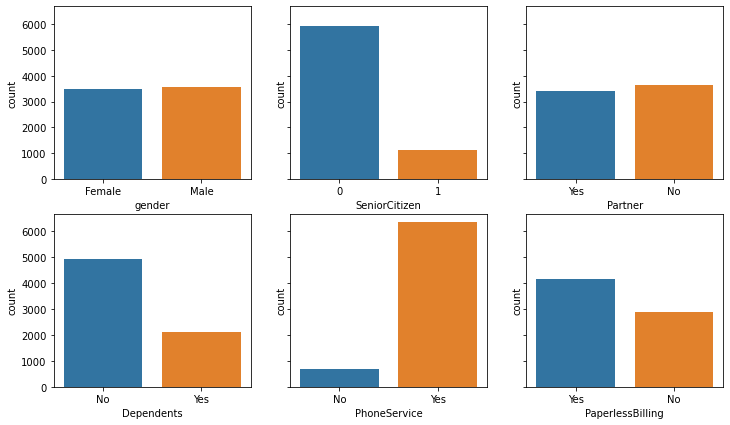

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True)

sns.countplot("gender", data=telecom, ax=axes[0,0]);
sns.countplot("SeniorCitizen", data=telecom, ax=axes[0,1]);
sns.countplot("Partner", data=telecom, ax=axes[0,2]);
sns.countplot("Dependents", data=telecom, ax=axes[1,0]);
sns.countplot("PhoneService", data=telecom, ax=axes[1,1]);
sns.countplot("PaperlessBilling", data=telecom, ax=axes[1,2]);

##### There is a high imbalance in SeniorCitizen and PhoneService variables. Most of the customers are not senior and similarly, most customers have a phone service.

##### It is better to check how the target variable (churn) changes according to the binary features. To be able to make calculations, we need to change the values of target variable. "Yes" will be 1 and "No" will be 0.

In [16]:
churn_numeric = {'Yes':1, 'No':0}
telecom.Churn.replace(churn_numeric, inplace=True)

In [17]:
telecom[['gender','Churn']].groupby(['gender']).mean()

,Churn
gender,
Female,0.269209
Male,0.261603


Average churn rate for males and females are approximately the same which indicates gender variable does not bring a valuable prediction power to a model. Therefore, I will not use gender variable in the machine learning model.

In [18]:
telecom[['SeniorCitizen','Churn']].groupby(['SeniorCitizen']).mean()

,Churn
SeniorCitizen,
0,0.236062
1,0.416813


In [19]:
telecom[['Partner','Churn']].groupby(['Partner']).mean()

,Churn
Partner,
No,0.329580
Yes,0.196649


In [20]:
telecom[['Dependents','Churn']].groupby(['Dependents']).mean()

,Churn
Dependents,
No,0.312791
Yes,0.154502


In [21]:
telecom[['PhoneService','Churn']].groupby(['PhoneService']).mean()

,Churn
PhoneService,
No,0.249267
Yes,0.267096


In [22]:
telecom[['PaperlessBilling','Churn']].groupby(['PaperlessBilling']).mean()

,Churn
PaperlessBilling,
No,0.163301
Yes,0.335651


##### We can also use pandas pivot_table function to check the relationship between features and target variable.

In [23]:
table = pd.pivot_table(telecom, values='Churn', index=['gender'],
                    columns=['SeniorCitizen'], aggfunc=np.mean)
table

SeniorCitizen,0,1
gender,,
Female,0.239384,0.422535
Male,0.232808,0.411150


In [24]:
table = pd.pivot_table(telecom, values='Churn', index=['Partner'],
                    columns=['Dependents'], aggfunc=np.mean)
table

Dependents,No,Yes
Partner,,
No,0.342378,0.213296
Yes,0.254083,0.142367


### Other Categorical Features

It is time to explore other categorical features. We also have continuous features such as tenure, monthly charges and total charges which I will discuss in the next part.

There are 6 variables that come with internet service. There variables come into play if customer has internet service.


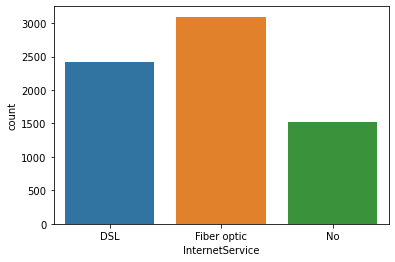

In [25]:
sns.countplot("InternetService", data=telecom);

In [26]:
telecom[['InternetService','Churn']].groupby('InternetService').mean()

,Churn
InternetService,
DSL,0.189591
Fiber optic,0.418928
No,0.074050


##### Internet service variable is definitely important in predicting churn rate. As you can see, customers with fiber optic internet service are much likely to churn than other customers although there is not a big difference in the number of customers with DSL and fiber optic. This company may have some problems with fiber optic connection. However, it is not a good way to make assumptions based on only one variable. Let's also check the monthly charges.

In [27]:
telecom[['InternetService','MonthlyCharges']].groupby('InternetService').mean()

,MonthlyCharges
InternetService,
DSL,58.102169
Fiber optic,91.500129
No,21.079194


##### Fiber optic service is much more expensive than DSL which may be one of the reasons why customers churn !

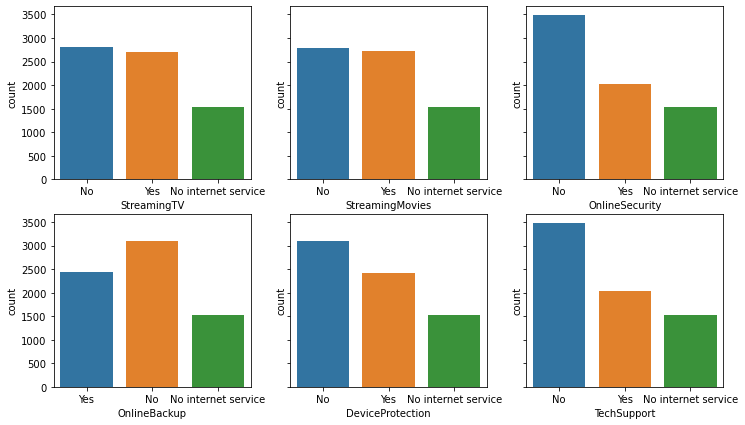

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True)

sns.countplot("StreamingTV", data=telecom, ax=axes[0,0]);
sns.countplot("StreamingMovies", data=telecom, ax=axes[0,1]);
sns.countplot("OnlineSecurity", data=telecom, ax=axes[0,2]);
sns.countplot("OnlineBackup", data=telecom, ax=axes[1,0]);
sns.countplot("DeviceProtection", data=telecom, ax=axes[1,1]);
sns.countplot("TechSupport", data=telecom, ax=axes[1,2]);

In [29]:
telecom[['StreamingTV','Churn']].groupby('StreamingTV').mean()

,Churn
StreamingTV,
No,0.335231
No internet service,0.074050
Yes,0.300702


In [30]:
telecom[['StreamingMovies','Churn']].groupby('StreamingMovies').mean()

,Churn
StreamingMovies,
No,0.336804
No internet service,0.074050
Yes,0.299414


In [31]:
telecom[['OnlineSecurity','Churn']].groupby('OnlineSecurity').mean()

,Churn
OnlineSecurity,
No,0.417667
No internet service,0.074050
Yes,0.146112


In [32]:
telecom[['OnlineBackup','Churn']].groupby('OnlineBackup').mean()

,Churn
OnlineBackup,
No,0.399288
No internet service,0.074050
Yes,0.215315


In [33]:
telecom[['DeviceProtection','Churn']].groupby('DeviceProtection').mean()

,Churn
DeviceProtection,
No,0.391276
No internet service,0.074050
Yes,0.225021


In [34]:
telecom[['TechSupport','Churn']].groupby('TechSupport').mean()

,Churn
TechSupport,
No,0.416355
No internet service,0.074050
Yes,0.151663


##### All internet service related features seem to have different churn rates for their classes.

In [35]:
telecom.PhoneService.value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [36]:
telecom.MultipleLines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

##### If a customer does not have a phone service, he/she cannot have multiple lines. MultipleLines column includes more specific data compared to PhoneService column. So I will not include PhoneService column as I can understand the number of people who have phone service from MultipleLines column. MultipleLines column takes the PhoneService column one step further.

In [37]:
telecom[['MultipleLines','Churn']].groupby('MultipleLines').mean()

,Churn
MultipleLines,
No,0.250442
No phone service,0.249267
Yes,0.286099


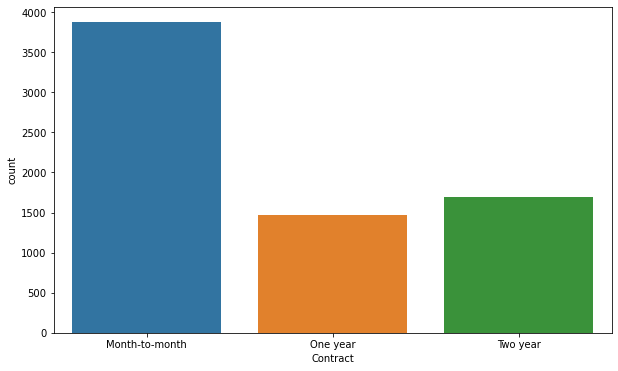

In [38]:
plt.figure(figsize=(10,6))
sns.countplot("Contract", data=telecom);

In [39]:
telecom[['Contract','Churn']].groupby('Contract').mean()

,Churn
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


#### It seems like, as expected, customers with short-term contract are more likely to churn. This clearly explains the motivation for companies to have long-term relationship with their customers.

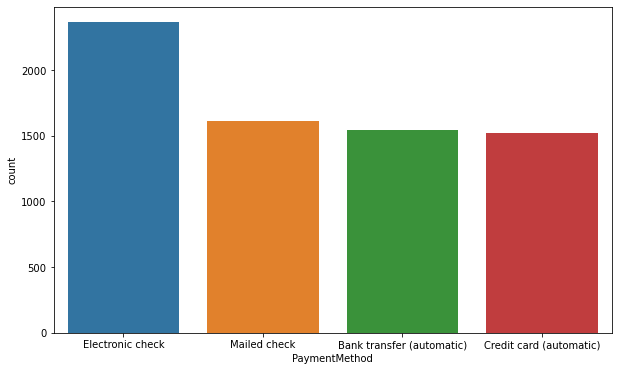

In [40]:
plt.figure(figsize=(10,6))
sns.countplot("PaymentMethod", data=telecom);

In [41]:
telecom[['PaymentMethod','Churn']].groupby('PaymentMethod').mean()

,Churn
PaymentMethod,
Bank transfer (automatic),0.167098
Credit card (automatic),0.152431
Electronic check,0.452854
Mailed check,0.191067


#### Continuous Variables

The continuous features are tenure, monthly charges and total charges. The amount in total charges columns is proportional to tenure (months) multiplied by monthly charges. So it is unnecessary to include total charges in the model. Adding unnecassary features will increase the model complexity. It is better to have a simpler model when possible. Complex models tend to overfit and not generalize well to new, previously unseen observations. Since the goal of a machine learning model is to predict or explain new observations, overfitting is a crucial issue.

Let's also have a look at the distribution of continuous features

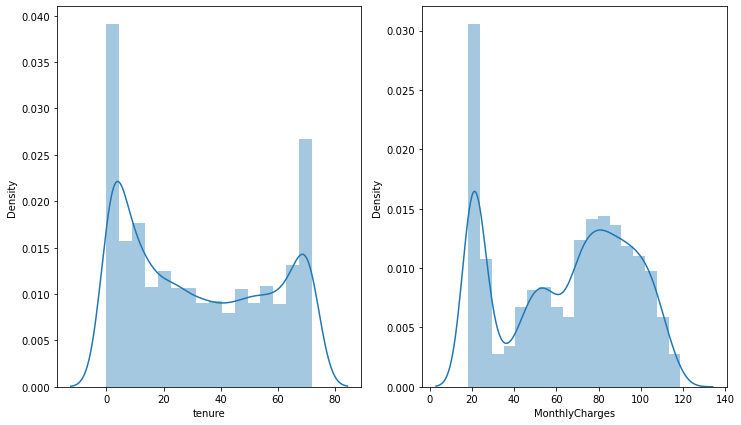

In [42]:
fig, axes = plt.subplots(1,2, figsize=(12, 7))

sns.distplot(telecom["tenure"], ax=axes[0]);
sns.distplot(telecom["MonthlyCharges"], ax=axes[1]);

In [43]:
telecom[['tenure','MonthlyCharges','Churn']].groupby('Churn').mean()

,tenure,MonthlyCharges
Churn,,
0,37.569965,61.265124
1,17.979133,74.441332


It is clear that people who have been a customer for a long time tend to stay with the company. The average tenure in months for people who left the company is 20 months less than the average for people who stay.

It seems like monthly charges also have an effect on churn rate.

Contract and tenure features may be correlated because customer with long term contract are likely to stay longer with the company. Let's figure out.

In [45]:
telecom[['Contract','tenure']].groupby('Contract').mean()

,tenure
Contract,
Month-to-month,18.036645
One year,42.044807
Two year,56.735103


As expected, contract and tenure are highly correlated. Customers with long contracts have been a customer for longer time than customers with short-term contracts. I think contract will add little to no value to tenure feature so I will not use contract feature in the model.

After exploring the variables, I have decided not to use following variable because they add little or no informative power to the model: 
- Customer ID 
- Gender
- PhoneService
- Contract
- TotalCharges


In [46]:
telecom.drop(['customerID','gender','PhoneService','Contract','TotalCharges'], axis=1, inplace=True)
telecom.head(1)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Yes,Electronic check,29.85,0


### Data Preprocessing


Categorical features need to be converted to numbers so that they can be included in calculations done by a machine learning model. The categorical variables in our data set are not ordinal (i.e. there is no order in them). For example, "DSL" internet service is not superior to "Fiber optic" internet service. An example for an ordinal categorical variable would be ratings from 1 to 5 or a variable with categories "bad", "average" and "good".

When we encode the categorical variables, a number will be assigned to each category. The category with higher numbers will be considered more important or effect the model more. Therefore, we need to do encode the variables in a way that each category will be represented by a column and the value in that column will be 0 or 1.

We also need to scale continuous variables. Otherwise, variables with higher values will be given more importance which effects the accuracy of the model.


In [47]:
cat_features = ['SeniorCitizen', 'Partner', 'Dependents',
        'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'PaymentMethod']
X = pd.get_dummies(telecom, columns=cat_features, drop_first=True)

In [48]:
sc = MinMaxScaler()
a = sc.fit_transform(telecom[['tenure']])
b = sc.fit_transform(telecom[['MonthlyCharges']])

In [49]:
X['tenure'] = a
X['MonthlyCharges'] = b

In [50]:
X.shape

(7043, 26)

##### Resampling

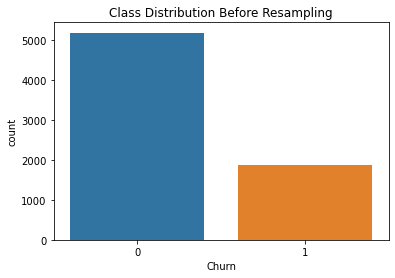

In [51]:
sns.countplot('Churn', data=telecom).set_title('Class Distribution Before Resampling');

In [52]:
X_no = X[X.Churn == 0]
X_yes = X[X.Churn == 1]

In [53]:
print(len(X_no),len(X_yes))

5174 1869


In [54]:
X_yes_upsampled = X_yes.sample(n=len(X_no), replace=True, random_state=42)
print(len(X_yes_upsampled))

5174


In [55]:
X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)

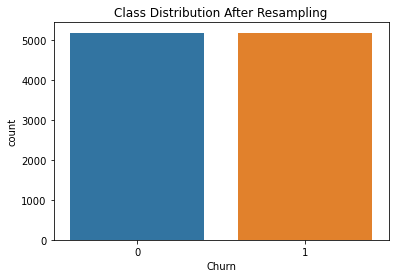

In [56]:
sns.countplot('Churn', data=X_upsampled).set_title('Class Distribution After Resampling');

## much better!!

## Model Building Starts

#### Segregate predictors vs target attributes

In [57]:
X = X_upsampled.drop(['Churn'], axis=1) #features (independent variables)
y = X_upsampled['Churn'] #target (dependent variable)

### Perform Test - Train Split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

### Model training, testing and tuning

##### I will start with Simple LR to begin with and then navigate to ensemble methods we learnt and then conclude on the best model.

### Simple Logistic Regression

In [59]:
classifier = LogisticRegression(solver='lbfgs' , max_iter=1000, C=1 , multi_class='multinomial', class_weight='balanced')

In [60]:
classifier.fit(X_train, y_train)
classifier.score(X_train, y_train)

0.7557641861107276

In [61]:
y_pred = classifier.predict(X_test)
classifier.score(X_test, y_test)

0.7607085346215781

In [62]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1208  385]
 [ 358 1154]]


In [63]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1593
           1       0.75      0.76      0.76      1512

    accuracy                           0.76      3105
   macro avg       0.76      0.76      0.76      3105
weighted avg       0.76      0.76      0.76      3105



### Logistic Regression with Hyperparameter Tuning

In [64]:
C = np.logspace(0.000001,2,10)
max_iter = np.arange(10,200,20)
solver_options = ['newton-cg', 'lbfgs', 'sag']

In [65]:
hyperparameters = dict(C=C, max_iter=max_iter, solver=solver_options)

In [66]:
clf = GridSearchCV(classifier, hyperparameters, cv=5, verbose=0)

In [67]:
best_model = clf.fit(X_train, y_train)

In [68]:
print("max iter : ",best_model.best_estimator_.get_params()['max_iter'])
print("C : ",best_model.best_estimator_.get_params()['C'])
print("solver : ",best_model.best_estimator_.get_params()['solver'])

max iter :  30
C :  100.0
solver :  sag


In [69]:
y_pred = best_model.predict(X_test)
best_model.score(X_test, y_test)

0.7607085346215781

In [70]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1212  381]
 [ 362 1150]]


### Decision Tree Classifiers

In [71]:
dt = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5, random_state=1, class_weight='balanced', presort=True)

In [72]:
dt.fit(X_train, y_train)
dt.score(X_train, y_train)

0.7585254728703575

In [73]:
y_pred = dt.predict(X_test)
dt.score(X_test, y_test)

0.7561996779388084

In [74]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

cr = classification_report(y_test, y_pred)
print(cr)

[[1078  515]
 [ 242 1270]]
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      1593
           1       0.71      0.84      0.77      1512

    accuracy                           0.76      3105
   macro avg       0.76      0.76      0.76      3105
weighted avg       0.77      0.76      0.75      3105



#### There's no point Hyperparameter tuning for DT, because we would rather build a random forest for this.

### Simple Random Forest

In [75]:
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', oob_score=True, class_weight='balanced', random_state=1)

In [76]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

0.996962584564407

this score is useless. because it is overfitting the training dataset. instead use oob_score to understand it's actual score

In [77]:
y_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.8927536231884058

In [78]:
print('Score: ', rfc.oob_score_)

Score:  0.883887891757559


In [79]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[1340  253]
 [  80 1432]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1593
           1       0.85      0.95      0.90      1512

    accuracy                           0.89      3105
   macro avg       0.90      0.89      0.89      3105
weighted avg       0.90      0.89      0.89      3105



### Random Forest with Hyperparameter Tuning

In [80]:
n_estimators = np.arange(10, 50, 10)
max_features = ['auto', 'sqrt', 'log2']

In [81]:
hyperparameters = dict(max_features = max_features, n_estimators=n_estimators)

In [82]:
clf = GridSearchCV(rfc, hyperparameters, cv=10, verbose=0)

In [83]:
best_model = clf.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.893719806763285

In [84]:
y_pred = best_model.predict(X_test)

In [85]:
print('n_estimators : ', best_model.best_estimator_.get_params()['n_estimators'])
print('max_features : ', best_model.best_estimator_.get_params()['max_features'])

n_estimators :  30
max_features :  auto


In [86]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[1353  240]
 [  90 1422]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1593
           1       0.86      0.94      0.90      1512

    accuracy                           0.89      3105
   macro avg       0.90      0.89      0.89      3105
weighted avg       0.90      0.89      0.89      3105



### Bagging Algorithms

In [87]:
bc = BaggingClassifier(n_estimators=30, max_samples=0.75, random_state=1, oob_score=True)

In [88]:
bc.fit(X_train, y_train)
bc.score(X_train, y_train)

0.9913019467071655

In [89]:
y_pred = bc.predict(X_test)
bc.score(X_test, y_test)

0.8830917874396135

In [90]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[1326  267]
 [  96 1416]]
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1593
           1       0.84      0.94      0.89      1512

    accuracy                           0.88      3105
   macro avg       0.89      0.88      0.88      3105
weighted avg       0.89      0.88      0.88      3105



### Bagging Classifier with Hyperparameter Tuning

In [92]:
n_estimators = np.arange(10,50,10)
max_samples = np.arange(0.7, 0.8, 0.05)

In [93]:
hyperparameters = dict(n_estimators=n_estimators, max_samples=max_samples)

In [94]:
clf = GridSearchCV(bc, hyperparameters, cv=5, verbose=0)

In [95]:
best_model = clf.fit(X_train, y_train)
best_model.score(X_train, y_train)

0.992544525748999

In [96]:
y_pred = best_model.predict(X_test)
best_model.score(X_test, y_test)

0.8840579710144928

In [97]:
print("n_estimators : ",best_model.best_estimator_.get_params()['n_estimators'])
print("max_samples : ",best_model.best_estimator_.get_params()['max_samples'])

n_estimators :  30
max_samples :  0.8


In [98]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[1325  268]
 [  92 1420]]
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1593
           1       0.84      0.94      0.89      1512

    accuracy                           0.88      3105
   macro avg       0.89      0.89      0.88      3105
weighted avg       0.89      0.88      0.88      3105



### Extra Trees Classifier

In [99]:
etc = ExtraTreesClassifier(n_estimators = 50, criterion='entropy', max_features='auto', min_samples_split=2, bootstrap=True, oob_score=True)

In [100]:
etc.fit(X_train, y_train)
etc.score(X_train, y_train)

0.9966864558884441

In [101]:
y_pred = etc.predict(X_test)
etc.score(X_test, y_test)

0.8801932367149758

In [102]:
etc.oob_score_

0.8812646693359105

In [103]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[1311  282]
 [  90 1422]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1593
           1       0.83      0.94      0.88      1512

    accuracy                           0.88      3105
   macro avg       0.89      0.88      0.88      3105
weighted avg       0.89      0.88      0.88      3105



### Ada Boosting Classifier

In [104]:
abc = AdaBoostClassifier(n_estimators=100, learning_rate=0.25, random_state=1)

In [105]:
abc.fit(X_train, y_train)
abc.score(X_train, y_train)

0.7668093331492476

In [106]:
y_pred = abc.predict(X_test)
abc.score(X_test, y_test)

0.7677938808373591

In [107]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[1207  386]
 [ 335 1177]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1593
           1       0.75      0.78      0.77      1512

    accuracy                           0.77      3105
   macro avg       0.77      0.77      0.77      3105
weighted avg       0.77      0.77      0.77      3105



### Ada Boosting Classifier With Hyperparameter Tuning

In [108]:
n_estimators = np.arange(30,100,10)
learning_rate = np.arange(0.1,1,0.5)

In [109]:
hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate)

In [110]:
clf = GridSearchCV(abc, hyperparameters, cv=3)

In [111]:
best_model = clf.fit(X_train, y_train)
best_model.score(X_train, y_train)

0.7643241750655806

In [112]:
y_pred = best_model.predict(X_test)
best_model.score(X_test, y_test)

0.7668276972624799

In [113]:
print('n_estimators : ', best_model.best_estimator_.get_params()['n_estimators'])
print('learning_rate : ', best_model.best_estimator_.get_params()['learning_rate'])

n_estimators :  80
learning_rate :  0.1


### Gradient Descent Boosting Classifier


In [114]:
gbc = GradientBoostingClassifier(loss='deviance', n_estimators=50, learning_rate=0.1, validation_fraction=0.2, random_state=1)

In [115]:
gbc.fit(X_train, y_train)
gbc.score(X_train, y_train)

0.7785448018776749

In [116]:
y_pred = gbc.predict(X_test)
gbc.score(X_test, y_test)

0.77487922705314

In [117]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[1182  411]
 [ 288 1224]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1593
           1       0.75      0.81      0.78      1512

    accuracy                           0.77      3105
   macro avg       0.78      0.78      0.77      3105
weighted avg       0.78      0.77      0.77      3105



### Gradient Descent Boosting Classifier with Hyperparameter Tuning

In [118]:
n_estimators = np.arange(30,100,10)
learning_rate = np.arange(0.1,1,0.5)

In [119]:
hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate)

In [120]:
clf = GridSearchCV(gbc, hyperparameters, cv=3)

In [121]:
best_model = clf.fit(X_train, y_train)
best_model.score(X_train, y_train)

0.8601408256247411

In [122]:
y_pred = best_model.predict(X_test)
best_model.score(X_test, y_test)

0.807085346215781

In [123]:
print('n_estimators : ', best_model.best_estimator_.get_params()['n_estimators'])
print('learning_rate : ', best_model.best_estimator_.get_params()['learning_rate'])

n_estimators :  90
learning_rate :  0.6


### Stacking 

In [124]:
stack = VotingClassifier(estimators=[('gbc',gbc),('abc',abc)], voting='hard')

In [125]:
for clf, label in zip([gbc, abc], ['Gradient Boosting', 'Ada Boosting']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.02f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label ))

Accuracy: 0.77 (+/- 0.00) [Gradient Boosting]
Accuracy: 0.76 (+/- 0.00) [Ada Boosting]


# Pickle It!!

In [126]:
import pickle

In [127]:
saved_model = pickle.dumps(gbc)

In [128]:
gbc_from_pickle = pickle.loads(saved_model)

In [129]:
gbc_from_pickle.predict(X_test)

array([1, 0, 1, ..., 0, 1, 0])

# Conclusions on Model selection

### Every model we tried did its respective job. however i liked the  radient Descent Boosting Classifier with Hyperparameter Tuning model more for its close proximity to predict between test and train data.


# How to improve

We can always try to improve the model. The fuel of machine learning models is data so if we can collect more data, it is always helpful in improving the model. We can also try a wider range of parameters in GridSearchCV because a little adjustment in a parameter may slighlty increase the model.

Finally, we can try more robust or advanced models. Please keep in mind that there will be a trade-off when making such kind of decisions. Advanced models may increase the accuracy but they require more data and more computing power.